In [1]:
 #importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib as pathlib

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

load dataset

In [2]:
# Load the QS World University Rankings dataset downloaded from kaggle
from google.colab import drive
drive.mount('/content/drive')


file_path = pathlib.Path("/content/drive/MyDrive/university_rankings.csv")
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


exploratory data analysis(EDA)

In [3]:
# Overview of the dataset
print("Dataset Shape:", df.shape)         # Number of rows and columns
print("Column Names:", df.columns.tolist())
df.head()

#Summary statistics for all numeric columns
df.describe()

# Check for data type and missing values
df.dtypes
df.isnull().sum()


Dataset Shape: (1501, 30)
Column Names: ['2026 Rank', 'Previous Rank', 'Institution Name', 'Country/Territory', 'Region', 'Size', 'Focus', 'Research', 'Status', 'AR SCORE', 'AR RANK', 'ER SCORE', 'ER RANK', 'FSR SCORE', 'FSR RANK', 'CPF SCORE', 'CPF RANK', 'IFR SCORE', 'IFR RANK', 'ISR SCORE', 'ISR RANK', 'ISD SCORE', 'ISD RANK', 'IRN SCORE', 'IRN RANK', 'EO SCORE', 'EO RANK', 'SUS SCORE', 'SUS RANK', 'Overall SCORE']


,0
2026 Rank,0
Previous Rank,112
Institution Name,0
Country/Territory,0
Region,0
Size,1
Focus,0
Research,1
Status,47
AR SCORE,0


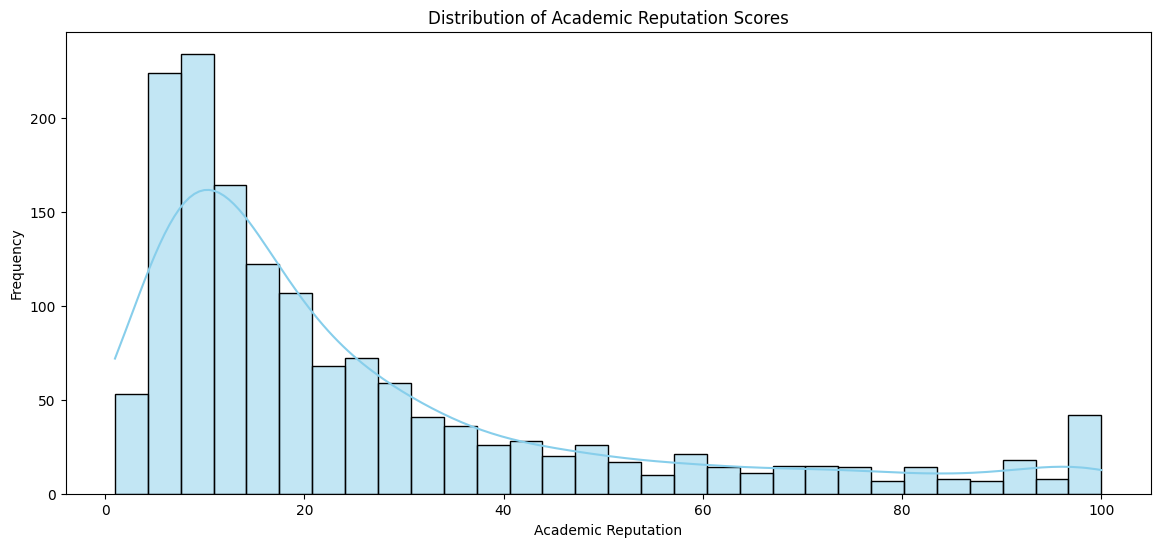

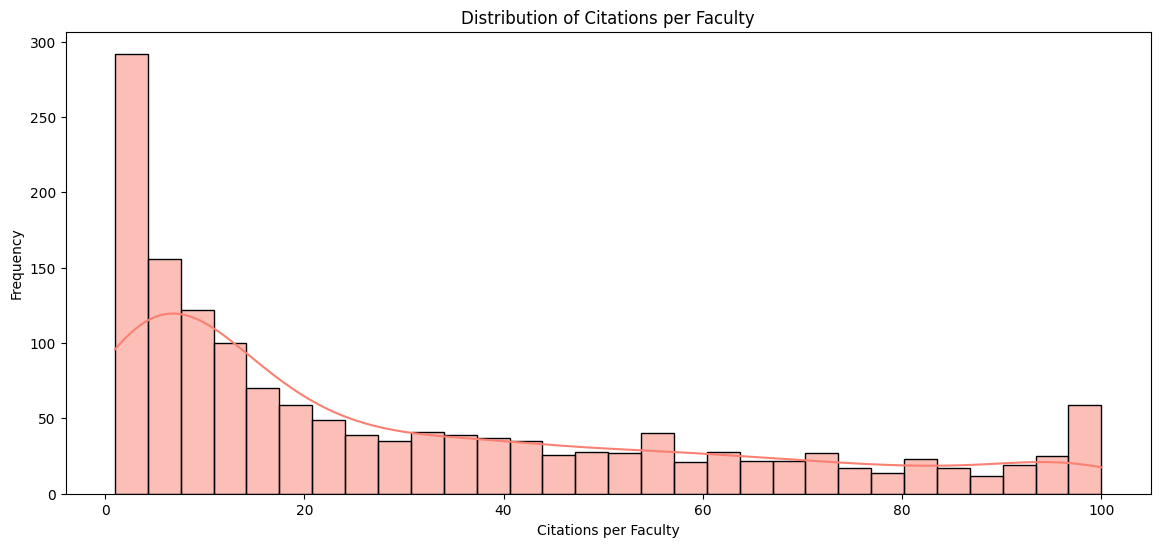

In [4]:
# Distribution plots of key numeric metrics
plt.figure(figsize=(14, 6))
sns.histplot(df['AR SCORE'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Academic Reputation Scores")
plt.xlabel("Academic Reputation")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(df['CPF SCORE'], kde=True, bins=30, color='salmon')
plt.title("Distribution of Citations per Faculty")
plt.xlabel("Citations per Faculty")
plt.ylabel("Frequency")
plt.show()

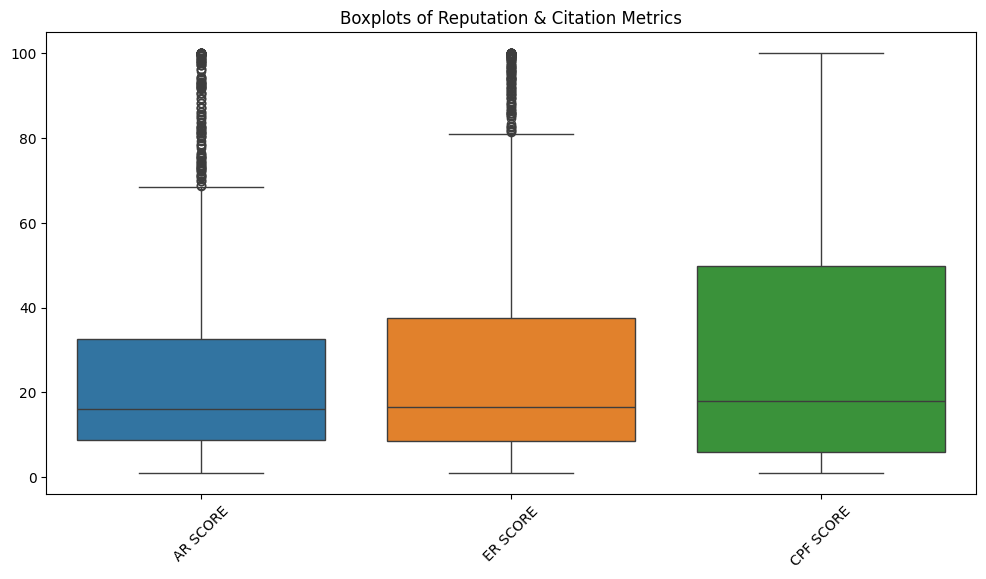

In [5]:
# Box plots to check for outliers in important features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['AR SCORE', 'ER SCORE', 'CPF SCORE']])
plt.title("Boxplots of Reputation & Citation Metrics")
plt.xticks(rotation=45)
plt.show()

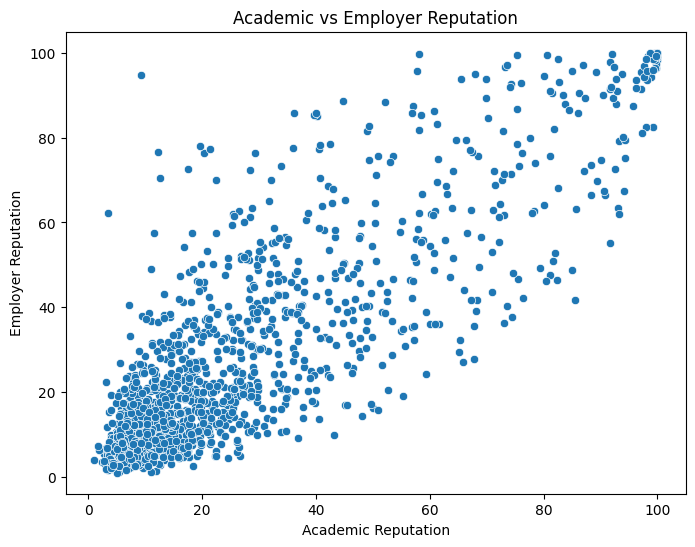

In [6]:
# Scatter plot: Academic Reputation vs Employer Reputation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AR SCORE', y='ER SCORE', data=df)
plt.title("Academic vs Employer Reputation")
plt.xlabel("Academic Reputation")
plt.ylabel("Employer Reputation")
plt.show()

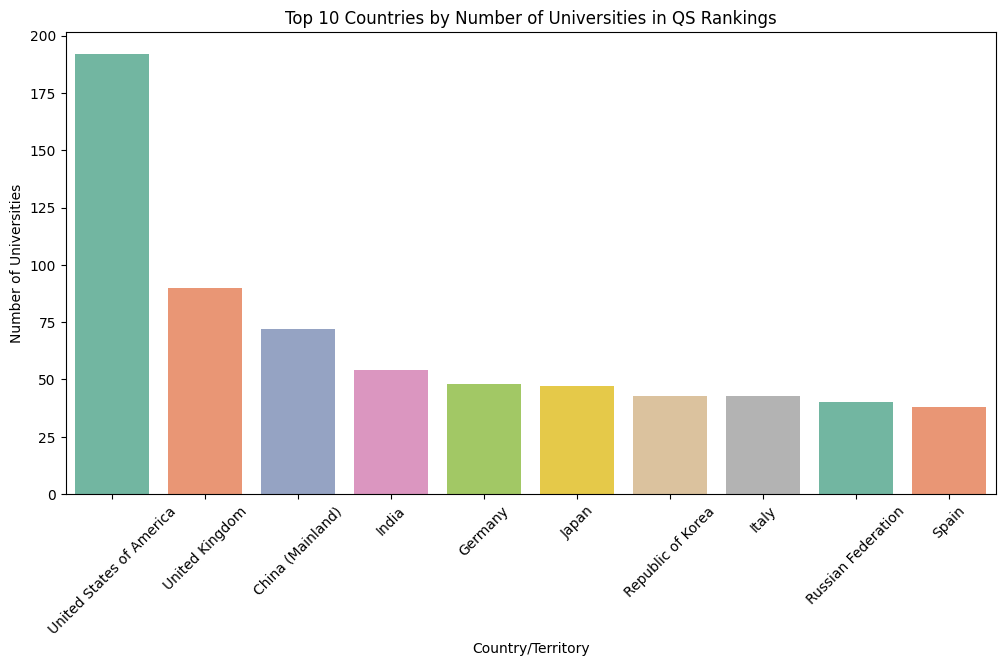

In [7]:
# universityy count per country
plt.figure(figsize=(12, 6))
top_countries = df['Country/Territory'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values, palette='Set2')
plt.title("Top 10 Countries by Number of Universities in QS Rankings")
plt.ylabel("Number of Universities")
plt.xticks(rotation=45)
plt.show()

feature selection and scaling

In [8]:
# Selecting relevant features for analysis
# Based on the dataset, we choose numeric and impactful ranking factors
features = ['ISR SCORE', 'IFR SCORE', 'FSR SCORE',
            'CPF SCORE', 'AR SCORE', 'ER SCORE']

# Create a copy of the DataFrame with just these features
df_model = df[features].copy()

In [9]:
#filling missing numerical values with the mean of their column.
df_model.fillna(df_model.mean(), inplace=True)


In [10]:
# Normalize the data (important for distance-based clustering)
scaler = StandardScaler()                 # Instantiate the scaler
X_scaled = scaler.fit_transform(df_model)  # Fit and transform the data


K-Means clustering

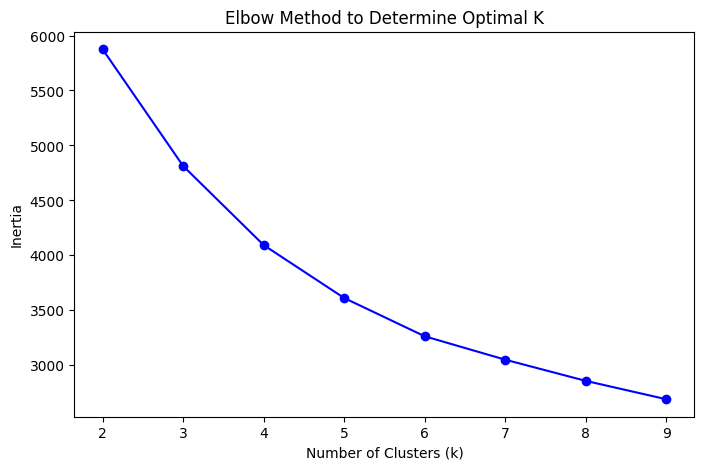

In [11]:
# Use the Elbow Method to find optimal number of clusters (K)
inertia = []  # Inertia = within-cluster sum of squares
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Store the inertia for each k

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.show()


In [12]:
# Apply K-Means Clustering with optimal k (k=4 based on elbow above)
kmeans = KMeans(n_clusters=4, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)  # Get cluster assignments
df['Cluster_KMeans'] = labels_kmeans          # Adds the cluster label to the original dataframe


In [13]:
# Evaluate the quality of clusters
silhouette = silhouette_score(X_scaled, labels_kmeans)
print("Silhouette Score for K-Means (k=4):", silhouette)


Silhouette Score for K-Means (k=4): 0.2803304810514392


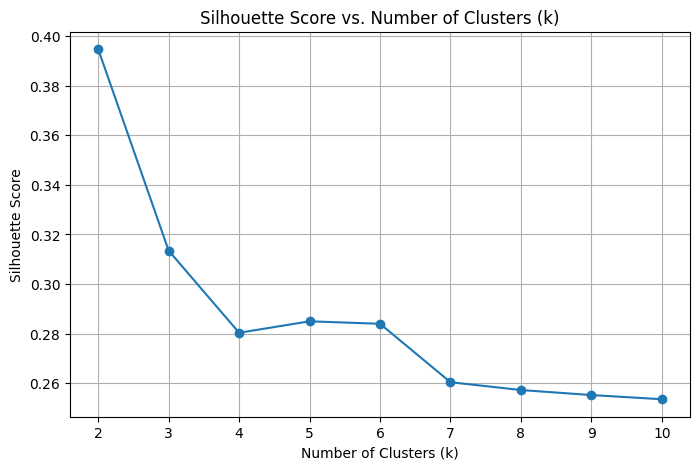

[np.float64(0.3947007256712791),
 np.float64(0.3134442155036409),
 np.float64(0.2803304810514392),
 np.float64(0.28494371995351636),
 np.float64(0.28395128068658687),
 np.float64(0.2603805685935941),
 np.float64(0.25721778679976876),
 np.float64(0.2551987889792242),
 np.float64(0.25351846844892845)]

In [14]:
# Compute silhouette scores for different values of k
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

silhouette_scores

PCA for Dimensionality Reduction & Visualization

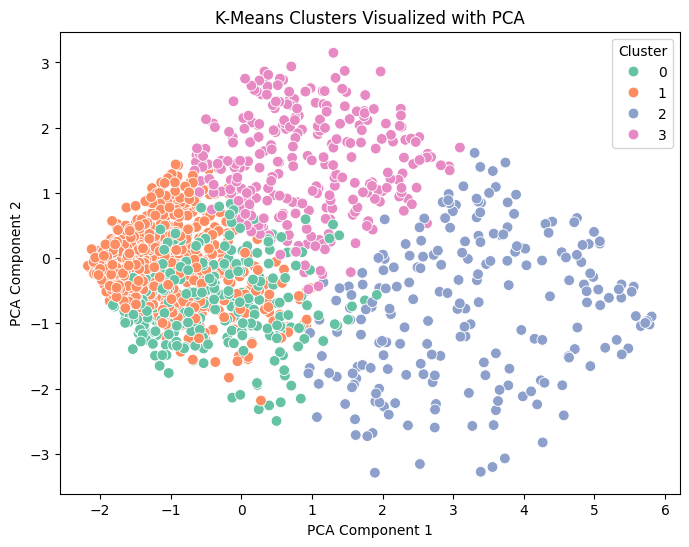

In [15]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA scatter plot with KMeans cluster colors
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='Set2', s=60)
plt.title("K-Means Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()


as in the visualisation shown above k=4, not only the silhoutte score is less but also the clusters are overlapping. so i choose the k with next better silhoutte score, which is 3 to check clusters again.

In [16]:
#changing the k value to make better clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)  # Get cluster assignments
df['Cluster_KMeans'] = labels_kmeans          # Add the cluster label to the original dataframe

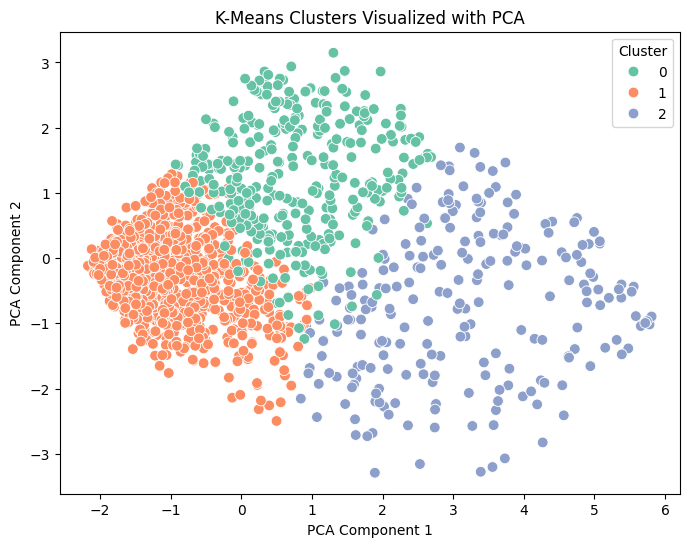

In [17]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA scatter plot with KMeans cluster colors
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='Set2', s=60)
plt.title("K-Means Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

Hierarchial clustering

In [18]:
# Hierarchical Clustering: Agglomerative method
hierarchical = AgglomerativeClustering(n_clusters=4)
labels_hier = hierarchical.fit_predict(X_scaled)
df['Cluster_Hierarchical'] = labels_hier  # Save labels to compare clustering methods


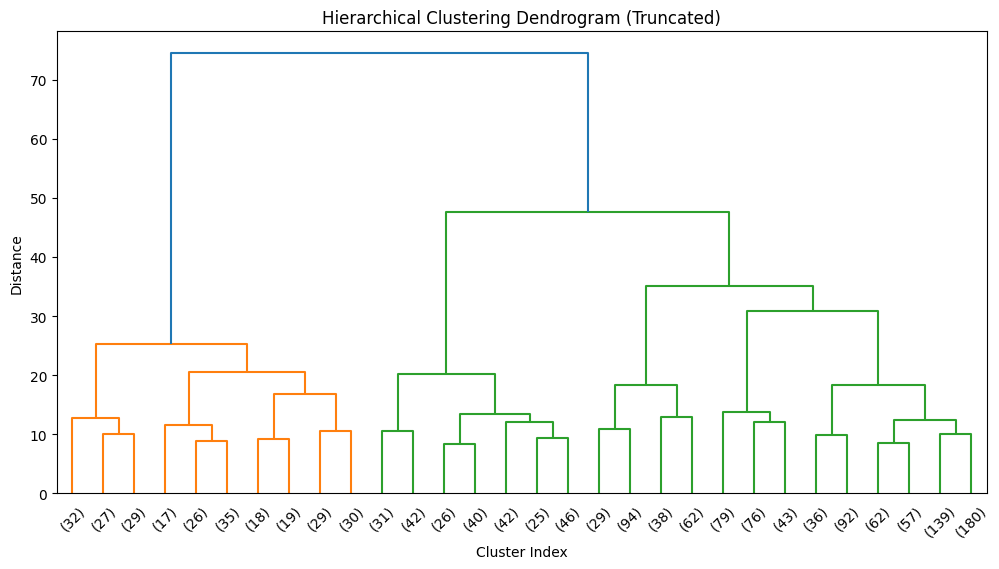

In [19]:
# Visualize Hierarchical Clustering using Dendrogram
linkage_matrix = linkage(X_scaled, method='ward')  # Ward linkage minimizes variance
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()


ranking universities by TIER using supervised classification (RandomForestClassifier)

In [20]:

# Assume df is your original dataframe
df = df.copy()

# Convert rank_display to numerical rank (remove "=" and non-numeric)
df['rank_numeric'] = df['2026 Rank'].str.extract('(\d+)').astype(float)

# Create rank tiers
def assign_tier(rank):
    if rank <= 100:
        return 'Top 100'
    elif rank <= 300:
        return '101-300'
    elif rank <= 600:
        return '301-600'
    else:
        return '601+'

df['rank_tier'] = df['rank_numeric'].apply(assign_tier)
df['rank_tier'] = df['rank_tier'].astype('category')


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop columns not needed
features = df.drop(columns=[ '2026 Rank', 'Previous Rank', 'Institution Name', 'Country/Territory', 'Region',
    'AR RANK', 'ER RANK', 'FSR RANK', 'CPF RANK', 'IFR RANK',
    'ISR RANK', 'ISD RANK', 'IRN RANK', 'EO RANK', 'SUS RANK','Overall SCORE',
                           'rank_numeric', 'rank_tier', 'Cluster_KMeans', 'Cluster_Hierarchical'])


# Separate numeric and categorical features
numeric_features = features.select_dtypes(include=np.number).columns.tolist()
categorical_features = features.select_dtypes(exclude=np.number).columns.tolist()

# Create preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


# Encode labels
y = df['rank_tier']



In [22]:
# First split: train and test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train and validation from the training portion
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

# Apply the preprocessor to the data
X_train_processed = model_pipeline.fit_transform(X_train)
X_val_processed = model_pipeline.transform(X_val)
X_test_processed = model_pipeline.transform(X_test)

Validation Set Classification Report:
              precision    recall  f1-score   support

     101-300       0.80      0.88      0.83        40
     301-600       0.83      0.74      0.78        61
        601+       0.94      0.98      0.96       179
     Top 100       1.00      0.75      0.86        20

    accuracy                           0.90       300
   macro avg       0.89      0.84      0.86       300
weighted avg       0.90      0.90      0.90       300

Validation Set Confusion Matrix:


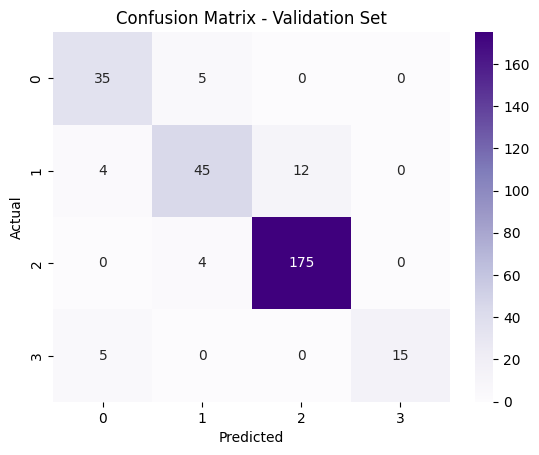

Test Set Classification Report:
              precision    recall  f1-score   support

     101-300       0.94      0.85      0.89        40
     301-600       0.82      0.77      0.80        61
        601+       0.93      0.98      0.95       180
     Top 100       1.00      0.90      0.95        20

    accuracy                           0.91       301
   macro avg       0.92      0.87      0.90       301
weighted avg       0.91      0.91      0.91       301

Test Set Confusion Matrix:


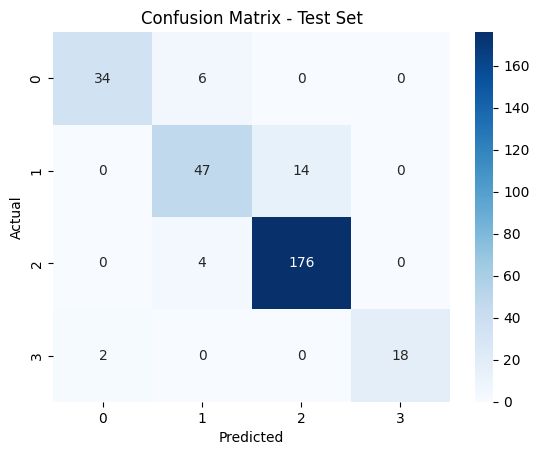

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_processed, y_train)

# Evaluate on Validation Set
y_val_pred = model.predict(X_val_processed)
print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Validation Set Confusion Matrix:")
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluate on Test Set
y_pred = model.predict(X_test_processed) # Assign predictions to y_pred
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

print("Test Set Confusion Matrix:")
cm_test = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Feature importance plot**
To gain a deeper understanding of the model's predictions, I recommend analyzing the feature importances. This will reveal which factors are most influential in determining a university's tier

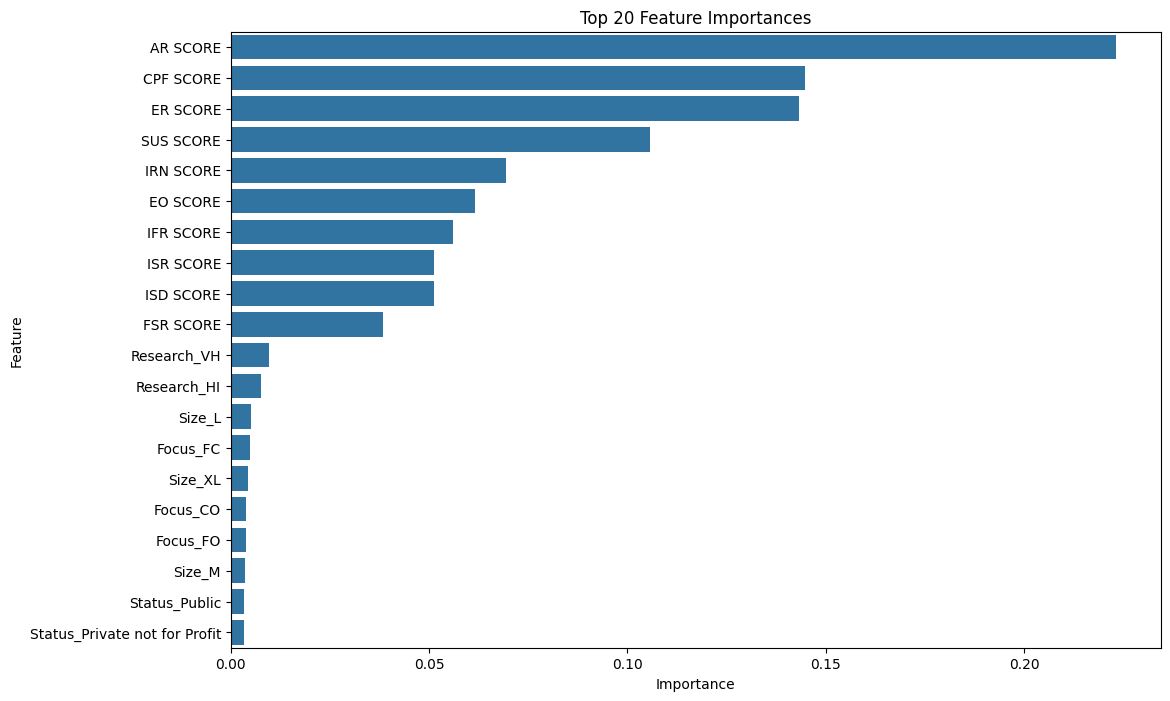

In [24]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Get the feature names after one-hot encoding
feature_names = numeric_features + \
                list(model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features))

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_processed, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Classification Report for Optimized Model:
              precision    recall  f1-score   support

     101-300       0.89      0.85      0.87        40
     301-600       0.84      0.67      0.75        61
        601+       0.91      0.99      0.95       180
     Top 100       1.00      0.90      0.95        20

    accuracy                           0.90       301
   macro avg       0.91      0.85      0.88       301
weighted avg       0.90      0.90      0.90       301

Confusion Matrix for Optimized Model:


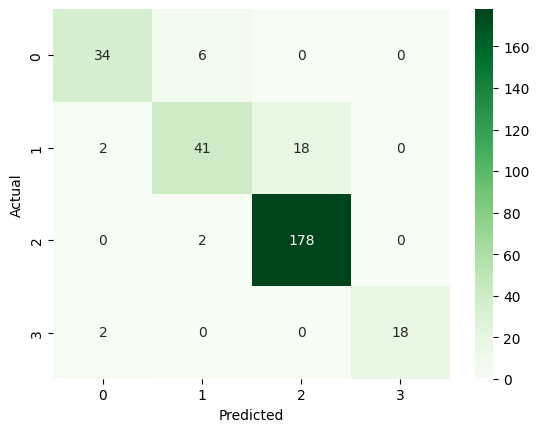

In [26]:
# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test_processed)

# Evaluate the optimized model
print("Classification Report for Optimized Model:")
print(classification_report(y_test, y_pred_best))

# Display the confusion matrix for the optimized model
print("Confusion Matrix for Optimized Model:")
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
cluster_summary = df.copy()
cluster_summary['Cluster'] = labels_kmeans  # cluster_labels from KMeans
summary_table = cluster_summary.groupby('Cluster')[['AR SCORE', 'ER SCORE', 'CPF SCORE',
                                                     'FSR SCORE', 'IFR SCORE', 'ISR SCORE']].mean().round(2)
print(summary_table)

         AR SCORE  ER SCORE  CPF SCORE  FSR SCORE  IFR SCORE  ISR SCORE
Cluster                                                                
0           21.35     22.49      34.97      33.33      74.48      64.99
1           15.50     17.05      20.98      29.21      13.82      14.71
2           73.98     73.58      62.37      54.11      65.53      61.09


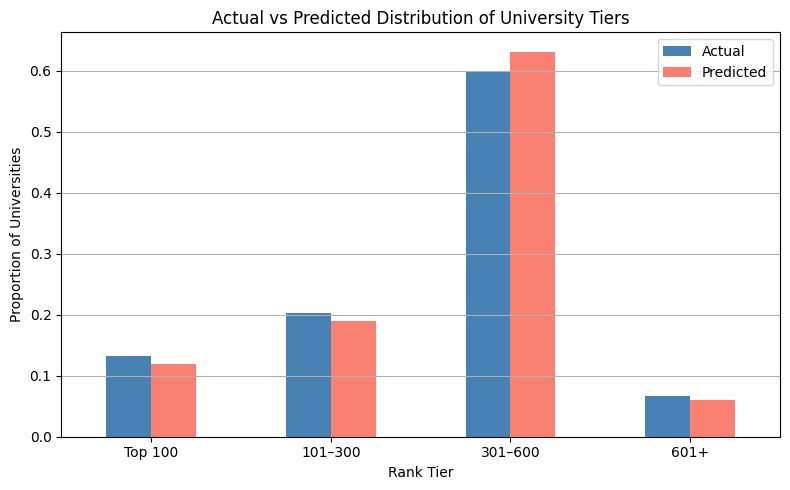

In [28]:
import matplotlib.pyplot as plt

# Convert test and predicted labels to series
actual_dist = pd.Series(y_test).value_counts().sort_index()
predicted_dist = pd.Series(y_pred).value_counts().sort_index()

# Normalize to proportions
actual_dist = actual_dist / actual_dist.sum()
predicted_dist = predicted_dist / predicted_dist.sum()

# Combine into a dataframe for side-by-side plotting
comparison_df = pd.DataFrame({'Actual': actual_dist, 'Predicted': predicted_dist})
comparison_df.plot(kind='bar', figsize=(8, 5), color=['steelblue', 'salmon'])

plt.title('Actual vs Predicted Distribution of University Tiers')
plt.xlabel('Rank Tier')
plt.ylabel('Proportion of Universities')
plt.xticks(ticks=[0,1,2,3], labels=['Top 100', '101–300', '301–600', '601+'], rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

downloading the data

In [29]:
from google.colab import files

# Select the columns you want to export.
# We'll include the institution name, location, ranks, scores, and cluster labels.
df_to_export = df[['Institution Name', 'Country/Territory', 'Region', '2026 Rank',
                   'Overall SCORE', 'AR SCORE', 'ER SCORE', 'FSR SCORE', 'CPF SCORE',
                   'Cluster_KMeans', 'Cluster_Hierarchical', 'rank_tier']]

# Save the dataframe to a CSV file
df_to_export.to_csv('university_clusters.csv', index=False)

# Download the file to your local machine
files.download('university_clusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>